In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from BinanceCollector import BinanceCollector
from TradeBook import TradeBook
import warnings
warnings.filterwarnings("ignore")
from BreakdownCalculator import BreakdownCalculator
from BinanceSync import BinanceSync
from sklearn.model_selection import train_test_split
from tensorflow import keras
from HyperBacktest import HyperBacktest
import matplotlib.pyplot as plt
import quantstats as qs
from datetime import datetime,timedelta

c:\Users\deves\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [14]:
symbol = "ETHUSDT"
collector = BinanceCollector(symbol,"2022-01-01","2023-01-02","15m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df
breakdown = BinanceCollector(symbol,"2022-01-01","2023-01-02","1m")
breakdown.start_collect()
breakdown.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
breakdown_df = breakdown.df
calculator = BreakdownCalculator(breakdown_df)

In [15]:
df["Open Time"] = pd.to_datetime(df["Open Time"],unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"]+1,unit="ms")
open_time = df["Open Time"]

In [16]:
df["EMA_20"] = df["Close"].ewm(span=20,adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50,adjust=False).mean()
df["EMA_200"] = df["Close"].ewm(span=200,adjust=False).mean()

df = df[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200","Open Time"]]

# Normalising Data
# df = (df - df.mean())/df.std()

In [17]:
# Filter dataframe for month
# df = df[df["Open Time"].dt.month == 4]
# df.reset_index(inplace=True)

In [18]:
df["Buy"] = np.where( (df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1) ),1,0 )
df["Sell"] = np.where( (df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1) ),1,0 )

# With 200 EMA condition
# df["Buy"] = np.where( (df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1) ) & ( df["EMA_50"] > df["EMA_200"] ),1,0 )
# df["Sell"] = np.where( (df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1) )& ( df["EMA_50"] < df["EMA_200"] ),1,0 )

df["Returns"] = 0

In [19]:
main = df.copy()
main.tail()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns
34765,1202.07,1202.07,1200.45,1201.03,1201.463525,1199.649774,1197.873140,2023-01-01 22:45:00,0,0,0
34766,1201.04,1202.49,1200.29,1202.15,1201.528903,1199.747822,1197.915696,2023-01-01 23:00:00,0,0,0
34767,1202.14,1202.37,1200.16,1200.17,1201.399484,1199.764378,1197.938127,2023-01-01 23:15:00,0,0,0
34768,1200.16,1201.30,1199.36,1200.66,1201.329057,1199.799500,1197.965210,2023-01-01 23:30:00,0,0,0
34769,1200.66,1201.00,1199.43,1200.34,1201.234861,1199.820696,1197.988840,2023-01-01 23:45:00,0,0,0


In [28]:
df = main.copy()
leverage = 1
backtest = HyperBacktest(4,-2,calculator,df,leverage=leverage)
backtest.run()
df = backtest.df
# calculate total portfolio value
start_balance = 20
df["Compounded Returns"] = (1 + df["Returns"]/100).cumprod()
df["Portfolio Value"] = df["Compounded Returns"] * start_balance
tmp = df.copy()
tmp = tmp.set_index("Open Time")
qs.reports.html(tmp["Returns"]/100, output="report.html",download_filename=f"report-{symbol}.html", title=f"Report {symbol} ({leverage}x leverage)")

Before Drop: 524
After Drop: 417


<AxesSubplot:>

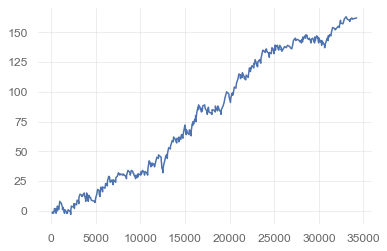

In [29]:
df["Returns"].cumsum().plot()
# df["Portfolio Value"].plot(figsize=(20,5))
# len(df[df["Returns"] != 0])

Text(0.5, 1.0, 'Monthly Returns ETHUSDT (1x)')

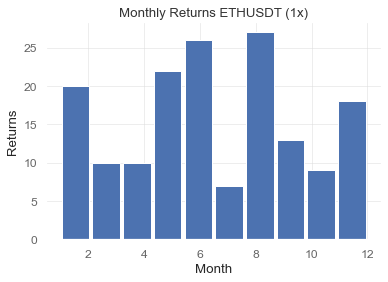

In [30]:
# Calculate monthly returns
returns = []
months = []
for i in range(1,13):
    months.append(i)
    r = df["Returns"][df["Open Time"].dt.month == i].sum()
    returns.append(r)

plt.hist(months,weights=returns,rwidth=0.9)
plt.xlabel("Month")
plt.ylabel("Returns")
plt.title(f"Monthly Returns {symbol} ({leverage}x)")

In [19]:
df.tail()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns,End,Gap,Compounded Returns,Portfolio Value
34296,11.03,11.06,11.02,11.06,11.017771,11.016329,11.177761,2022-12-28 00:30:00,1,0,-1,2022-12-28 03:02:00,695.0,9.068854,181.377076
34298,11.01,11.03,10.88,10.91,11.006837,11.011921,11.173444,2022-12-28 01:00:00,0,1,4,2022-12-28 05:15:00,625.0,9.431608,188.632159
34515,9.15,9.19,9.09,9.12,9.369460,9.375468,9.696642,2022-12-30 07:45:00,0,1,-1,2022-12-30 12:33:00,3163.0,9.337292,186.745838
34537,9.60,9.69,9.56,9.61,9.307398,9.300055,9.602939,2022-12-30 13:15:00,1,0,-1,2022-12-30 14:49:00,3360.0,9.243919,184.878380
34691,9.89,9.90,9.85,9.88,9.981980,9.986409,9.857212,2023-01-01 04:15:00,0,1,-1,2023-01-01 23:44:00,2382.0,9.151480,183.029596


In [20]:
df[ (df["Buy"] == 1) & (df["Returns"] < 0) ]

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns,End,Gap,Compounded Returns,Portfolio Value
160,176.44,177.25,176.32,177.23,176.101880,176.087689,174.701539,2022-01-02 16:30:00,1,0,-1,2022-01-03 02:07:00,1203.0,0.990000,19.800000
242,174.08,175.44,173.96,175.32,174.169357,174.106377,174.521754,2022-01-03 13:15:00,1,0,-1,2022-01-03 15:51:00,597.0,0.980100,19.602000
330,171.02,172.28,170.80,171.78,169.149181,169.012690,171.452074,2022-01-04 11:30:00,1,0,-1,2022-01-04 18:40:00,909.0,0.970299,19.405980
407,170.09,170.50,169.69,170.43,169.111893,169.076813,170.386920,2022-01-05 07:00:00,1,0,-1,2022-01-05 17:36:00,740.0,0.999020,19.980397
546,152.23,153.57,151.95,153.36,150.408957,150.328467,158.156263,2022-01-06 18:00:00,1,0,-1,2022-01-06 23:52:00,1464.0,0.989030,19.780593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33991,11.52,11.53,11.49,11.52,11.434335,11.429781,11.665064,2022-12-24 19:15:00,1,0,-1,2022-12-25 14:34:00,1785.0,9.078678,181.573554
34115,11.41,11.44,11.39,11.43,11.375171,11.373409,11.474221,2022-12-26 02:45:00,1,0,-1,2022-12-26 15:36:00,2723.0,8.987891,179.757818
34202,11.29,11.31,11.26,11.30,11.251690,11.251567,11.355270,2022-12-27 00:45:00,1,0,-2,2022-12-27 12:55:00,2051.0,8.808133,176.162662
34296,11.03,11.06,11.02,11.06,11.017771,11.016329,11.177761,2022-12-28 00:30:00,1,0,-1,2022-12-28 03:02:00,695.0,9.068854,181.377076


In [21]:
# Optimizing data for profitable buy signals
x = df[ df["Buy"] == 1 ]
y = np.where( x["Returns"] > 2,1 ,0 )
x = x[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200"]]

In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train = np.reshape( np.array(x_train), (x_train.shape[0],1,x_train.shape[1]) )
x_test = np.reshape( np.array(x_test), (x_test.shape[0],1,x_test.shape[1]) )

In [23]:
model = keras.Sequential([
    keras.layers.GRU(12,return_sequences=True,input_shape=(1,7)),
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dense(4,activation="tanh"),
    keras.layers.Dense(2),
    keras.layers.Softmax()
])

# keras.losses.c

model.compile(optimizer="ftrl",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train,epochs=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 198 samples
Epoch 1/10
198/198 [==============================] - 0s 3ms/sample - loss: 0.7113 - acc: 0.6408
Epoch 2/10
198/198 [==============================] - 0s 227us/sample - loss: 0.6919 - acc: 0.6926
Epoch 3/10
198/198 [==============================] - 0s 212us/sample - loss: 0.6913 - acc: 0.7052
Epoch 4/10
198/198 [==============================] - 0s 253us/sample - loss: 0.6909 - acc: 0.6883
Epoch 5/10
198/198 [==============================] - 0s 399us/sample - loss: 0.6904 - acc: 0.6841
Epoch 6/10
198/198 [==============================] - 0s 217us/sample - loss: 0.6900 - acc: 0.6841
Epoch 7/10
198/198 [==============================] - 0s 227us/sample - loss: 0.6896 - acc: 0.

In [24]:
model.evaluate(x_test,y_test)

50/50 [==============================] - 0s 5ms/sample - loss: 0.6878 - acc: 0.7404


[0.6878474903106689, 0.7403561]

In [25]:
tmp = x_train[3]
tmp_r = y_train[3]
tmp = np.reshape(tmp,(1,1,7))

In [26]:
model.predict(tmp)

array([[[0.50610363, 0.49389634]]], dtype=float32)

In [27]:
df = df.set_index("Open Time")
# df = df[ df["Returns"] != 0 ]

In [28]:
qs.reports.html(df["Returns"]/100, output="report.html",download_filename=f"report-{symbol}.html", title=f"Report {symbol}")

In [29]:
trades = df[ df["Buy"] == 1 ]
trades.reset_index(inplace=True)

In [30]:
trades["Gap"] = (trades["Open Time"] - trades["End"].shift(1).fillna(datetime.now())).apply(lambda x: x.total_seconds()/60)
trades = trades[1:]

<AxesSubplot:>

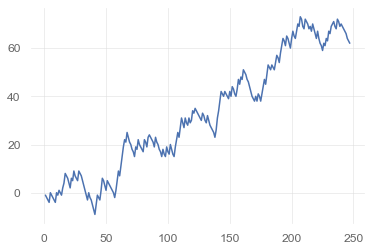

In [31]:
trades[ trades["Gap"] >= 0 ]['Returns'].cumsum().plot()

In [32]:
trades.drop( trades[ trades["Gap"] < 0 ].index )

,Open Time,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Buy,Sell,Returns,End,Gap,Compounded Returns,Portfolio Value
1,2022-01-03 13:15:00,174.08,175.44,173.96,175.32,174.169357,174.106377,174.521754,1,0,-1,2022-01-03 15:51:00,668.0,0.980100,19.602000
2,2022-01-04 11:30:00,171.02,172.28,170.80,171.78,169.149181,169.012690,171.452074,1,0,-1,2022-01-04 18:40:00,1179.0,0.970299,19.405980
3,2022-01-05 07:00:00,170.09,170.50,169.69,170.43,169.111893,169.076813,170.386920,1,0,-1,2022-01-05 17:36:00,740.0,0.999020,19.980397
4,2022-01-06 18:00:00,152.23,153.57,151.95,153.36,150.408957,150.328467,158.156263,1,0,-1,2022-01-06 23:52:00,1464.0,0.989030,19.780593
5,2022-01-08 04:30:00,140.13,141.05,139.55,141.00,139.463766,139.377579,145.206338,1,0,4,2022-01-08 09:09:00,1718.0,1.028591,20.571817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2022-12-24 19:15:00,11.52,11.53,11.49,11.52,11.434335,11.429781,11.665064,1,0,-1,2022-12-25 14:34:00,3147.0,9.078678,181.573554
244,2022-12-26 02:45:00,11.41,11.44,11.39,11.43,11.375171,11.373409,11.474221,1,0,-1,2022-12-26 15:36:00,731.0,8.987891,179.757818
245,2022-12-27 00:45:00,11.29,11.31,11.26,11.30,11.251690,11.251567,11.355270,1,0,-2,2022-12-27 12:55:00,549.0,8.808133,176.162662
246,2022-12-28 00:30:00,11.03,11.06,11.02,11.06,11.017771,11.016329,11.177761,1,0,-1,2022-12-28 03:02:00,695.0,9.068854,181.377076


In [33]:
df[ (df['End'] != 0) & (df["Returns"] > 0) ]

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Buy,Sell,Returns,End,Gap,Compounded Returns,Portfolio Value
Open Time,,,,,,,,,,,,,,
2022-01-04 19:15:00,169.17,169.48,168.28,168.60,170.261165,170.307901,171.348572,0,1,4,2022-01-05 19:14:00,1644.0,1.009111,20.182219
2022-01-08 04:30:00,140.13,141.05,139.55,141.00,139.463766,139.377579,145.206338,1,0,4,2022-01-08 09:09:00,3416.0,1.028591,20.571817
2022-01-08 17:00:00,140.73,141.24,139.05,139.16,143.566914,143.604836,144.874246,0,1,5,2022-01-08 18:11:00,2468.0,1.080020,21.600408
2022-01-10 10:45:00,141.19,141.58,140.84,140.88,141.775129,141.829982,142.186175,0,1,4,2022-01-10 13:16:00,368.0,1.068172,21.363444
2022-01-11 12:30:00,136.80,137.10,136.21,137.06,136.112470,136.096648,138.018477,1,0,4,2022-01-11 17:09:00,101.0,1.088792,21.775844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20 17:15:00,12.21,12.23,12.17,12.21,12.291988,12.292413,12.309840,0,1,1,2022-12-21 17:14:00,1123.0,8.904173,178.083468
2022-12-22 07:15:00,12.06,12.08,12.04,12.04,12.076778,12.077039,12.136098,0,1,1,2022-12-23 07:14:00,841.0,8.903283,178.065660
2022-12-23 07:45:00,11.88,11.90,11.88,11.89,11.926368,11.927577,12.009756,0,1,3,2022-12-24 05:22:00,1017.0,9.170381,183.407630
